# Imports and setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.random_projection import GaussianRandomProjection
from xgboost import XGBRegressor
from time import time
warnings.filterwarnings('ignore')

In [ ]:
ds = pd.read_csv('dataset_ver3.2.3.csv')
ds.head()

,Season,GW,Player,Date,Team,Opposition,Start,Pos,Min,Performance|Gls,...,AstGW,CSGW,Ret,Points,for: Dist_avg,for: npxG_sum,for: npxG/Sh_avg,against: Dist_avg,against: npxG_sum,against: npxG/Sh_avg
0,2017-2018,2,Marko Arnautovic,"[datetime.date(2017, 8, 13)]",WHU,['MUN_A'],['Y'],"['LW,LM']",90.0,0,...,0.0,0.0,0.0,-2.0,17.8,0.5,0.05,18.3,2.1,0.10
1,2017-2018,2,Ryan Bertrand,"[datetime.date(2017, 8, 12)]",SOU,['SWA_H'],['Y'],['LB'],85.0,0,...,0.0,0.0,0.0,1.0,17.8,2.0,0.07,15.6,0.3,0.07
2,2017-2018,2,Abdoulaye Doucoure,"[datetime.date(2017, 8, 12)]",WAT,['LIV_H'],['Y'],['CM'],90.0,1,...,0.0,1.0,0.0,3.0,15.9,2.1,0.25,13.9,1.8,0.14
3,2017-2018,2,Jonathan Walters,"[datetime.date(2017, 8, 12)]",BUR,['CHE_A'],['N'],['FW'],16.0,0,...,0.0,0.0,0.0,1.0,14.5,0.6,0.07,21.3,1.5,0.08
4,2017-2018,2,Antonio Valencia,"[datetime.date(2017, 8, 13)]",MUN,['WHU_H'],['Y*'],['RB'],90.0,0,...,0.0,1.0,1.0,6.0,18.3,2.1,0.10,17.8,0.5,0.05


In [ ]:
np.unique(ds['Season'])

array(['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022',
       '2022-2023', '2023-2024'], dtype=object)

In [ ]:
# Create a mapping of seasons to numbers
season_mapping = {
    '2017-2018': 1,
    '2018-2019': 2,
    '2019-2020': 3,
    '2020-2021': 4,
    '2021-2022': 5,
    '2022-2023': 6,
    '2023-2024': 7
}

# Replace season names with corresponding numbers
ds['Season'] = ds['Season'].map(season_mapping)

# Identify non-numeric columns (excluding 'Player')
non_numeric_cols = ds.select_dtypes(exclude=np.number).columns
cols_to_delete = [col for col in non_numeric_cols if col != 'Player']

# Delete identified columns
ds = ds.drop(columns=cols_to_delete)

# Calculate NewGW
ds['NewGW'] = (ds['Season'] - 1) * 38 + ds['GW']
ds = ds.drop(columns=['GW', 'Season'])
ds.head()

,Player,Min,Performance|Gls,Performance|Ast,Performance|PK,Performance|PKatt,Performance|Sh,Performance|SoT,Performance|CrdY,Performance|CrdR,...,CSGW,Ret,Points,for: Dist_avg,for: npxG_sum,for: npxG/Sh_avg,against: Dist_avg,against: npxG_sum,against: npxG/Sh_avg,NewGW
0,Marko Arnautovic,90.0,0,0,0,0,2,0,0,0,...,0.0,0.0,-2.0,17.8,0.5,0.05,18.3,2.1,0.10,2
1,Ryan Bertrand,85.0,0,0,0,0,1,0,0,0,...,0.0,0.0,1.0,17.8,2.0,0.07,15.6,0.3,0.07,2
2,Abdoulaye Doucoure,90.0,1,0,0,0,1,1,0,0,...,1.0,0.0,3.0,15.9,2.1,0.25,13.9,1.8,0.14,2
3,Jonathan Walters,16.0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,14.5,0.6,0.07,21.3,1.5,0.08,2
4,Antonio Valencia,90.0,0,0,0,0,1,0,1,0,...,1.0,1.0,6.0,18.3,2.1,0.10,17.8,0.5,0.05,2


In [ ]:
# Number of unique players
num_players = len(ds['Player'].unique())

# Number of current columns (excluding 'Player' and 'NewGW')
num_cols = len(ds.columns)

# Number of unique NewGW values
num_newgw = len(ds['NewGW'].unique())

# Create an empty tensor (NumPy array)
tensor_ds = np.zeros((num_players, num_cols, num_newgw))

# Iterate through the DataFrame and populate the tensor
player_mapping = {player: i for i, player in enumerate(ds['Player'].unique())}
newgw_mapping = {newgw: i for i, newgw in enumerate(ds['NewGW'].unique())}


for index, row in ds.iterrows():
    player_index = player_mapping[row['Player']]
    newgw_index = newgw_mapping[row['NewGW']]

    # Iterate through the remaining columns and populate the tensor
    for i, col in enumerate(ds.columns):
      if col not in ['Player', 'NewGW']:
        tensor_ds[player_index, i, newgw_index] = row[col]

# Replace NaN values with 0
tensor_ds = np.nan_to_num(tensor_ds)
print(tensor_ds.shape)

(1416, 111, 258)


In [ ]:
# Find the index of the 'Points' column in the original DataFrame 'ds'
try:
  points_index = ds.columns.get_loc('Points')
  print(f"The index of the 'Points' column in the DataFrame is: {points_index}")

  # Now, use this index to access the corresponding data in the tensor
  # Example: Accessing the points for the first player, in the first game week
  # print(tensor_ds[0, points_index, 0])

except KeyError:
  print("'Points' column not found in the DataFrame.")

The index of the 'Points' column in the DataFrame is: 103


In [ ]:
# Define the number of weeks to look back for prediction
lookback = 5

# Define the training and testing data indices
train_end = 200
test_start = 201
test_end = 258

# Prepare the training data
X_train = []
y_train = []

# Iterate over each player
for player_index in range(tensor_ds.shape[0]):
    # Iterate over the training weeks for the current player
    for i in range(train_end - lookback):
        if (tensor_ds[player_index, 103, i + lookback] == 0):
            continue
        X_train.append(tensor_ds[player_index, :, i:i + lookback])  # Keep 3D shape
        y_train.append(tensor_ds[player_index, 103, i + lookback])  # Predict 'points' (assuming it's the first column)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape

(48703, 111, 5)

In [ ]:
# Prepare the testing data
X_test = []
y_test = []

# Iterate over each player
for player_index in range(tensor_ds.shape[0]):
    # Iterate over the testing weeks for the current player
    for i in range(test_start - lookback, test_end - lookback):
        X_test.append(tensor_ds[player_index, :, i:i + lookback])  # Keep 3D shape
        y_test.append(tensor_ds[player_index, 103, i + lookback])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape

(80712, 111, 5)

# Raw data training

In [ ]:
n_components_values = range(1, 102, 5)
lin_times = {}
lin_errors = {}
for n_components in n_components_values:
    print(f"N_components: {n_components}")
    linear = LinearRegression()
    timing, error = training_loop(linear, X_train, X_test, y_train, y_test, n_components = n_components)
    print()
    lin_times[n_components] = timing
    lin_errors[n_components] = error

N_components: 1
SVD - Mean Squared Error: 9.1279
SVD - Mean Absolute Error: 2.8644
SVD - Reduction time: 3.8776 seconds
SVD - Train time: 0.0042 seconds

N_components: 6
SVD - Mean Squared Error: 8.0165
SVD - Mean Absolute Error: 2.6657
SVD - Reduction time: 4.1134 seconds
SVD - Train time: 0.0327 seconds

N_components: 11
SVD - Mean Squared Error: 7.5348
SVD - Mean Absolute Error: 2.5735
SVD - Reduction time: 3.1064 seconds
SVD - Train time: 0.1045 seconds

N_components: 16
SVD - Mean Squared Error: 6.6002
SVD - Mean Absolute Error: 2.3797
SVD - Reduction time: 2.5697 seconds
SVD - Train time: 0.1058 seconds

N_components: 21
SVD - Mean Squared Error: 6.8122
SVD - Mean Absolute Error: 2.4257
SVD - Reduction time: 3.0522 seconds
SVD - Train time: 0.1438 seconds

N_components: 26
SVD - Mean Squared Error: 6.7592
SVD - Mean Absolute Error: 2.4151
SVD - Reduction time: 4.3132 seconds
SVD - Train time: 0.0532 seconds

N_components: 31
SVD - Mean Squared Error: 6.4715
SVD - Mean Absolute Er

In [ ]:
# Create a Linear Regression model
model = LinearRegression()

# Record the start time
start_time = time.time()

# Fit the model to the training data
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Make predictions on the training data
y_pred_train = model.predict(X_train.reshape(X_train.shape[0], -1))

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_pred_train)

# Print the results
print(f"Training Time: {training_time:.4f} seconds")
print(f"Mean Squared Error (MSE): {mse:.4f}")

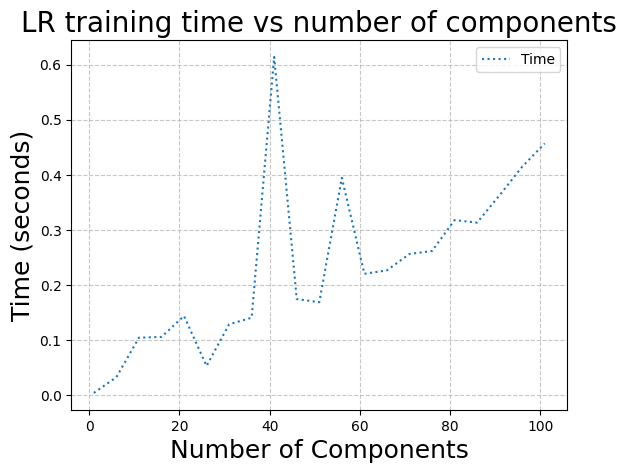

In [ ]:
plt.plot(n_components_values, lin_times.values(), label='Time', linestyle=':')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Time (seconds)', fontsize=18)
plt.title('LR training time vs number of components',  fontsize=20)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.plot(n_components_values, lin_errors.values(), label='Test MSE', linestyle=':')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Test MSE', fontsize=18)
plt.title('LR test MSE vs number of components',  fontsize=20)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
n_components_values = range(1, 102, 5)
xgb_times = {}
xgb_errors = {}
for n_components in n_components_values:
    print(f"N_components: {n_components}")
    xgb = XGBRegressor()
    timing, error = training_loop(linear, X_train, X_test, y_train, y_test, n_components = n_components)
    print()
    xgb_times[n_components] = timing
    xgb_errors[n_components] = error

In [ ]:
plt.plot(n_components_values, xgb_times.values(), label='Time', linestyle='--', color = 'green')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Time (seconds)', fontsize=18)
plt.title('XGB training time vs number of components',  fontsize=20)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

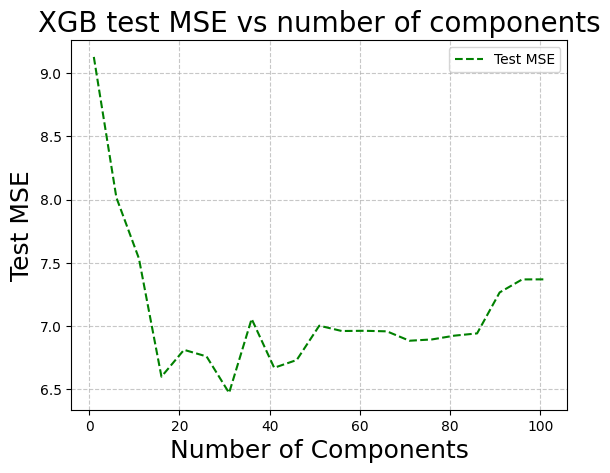

In [ ]:
plt.plot(n_components_values, xgb_errors.values(), label='Test MSE', linestyle='--', color = 'green')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Test MSE', fontsize=18)
plt.title('XGB test MSE vs number of components',  fontsize=20)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
#linear
rp_mse_values = []
rp_mae_values = []
rp_reduction_times = []
rp_train_times = []
rp_history = []

for n_components in n_components_values:
    #print(f"N_components: {n_components}")
    model = LinearRegression()
    mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, 'rp', n_components=n_components)
    rp_mse_values.append(mse)
    rp_mae_values.append(mae)
    rp_reduction_times.append(reduction_time)
    rp_train_times.append(train_time)
    plt.figure(figsize=(10, 6))

svd_mse_values = []
svd_mae_values = []
svd_reduction_times = []
svd_train_times = []
svd_history = []

for n_components in n_components_values:
    #print(f"N_components: {n_components}")
    model = LinearRegression()
    mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, 'svd', n_components=n_components)
    svd_mse_values.append(mse)
    svd_mae_values.append(mae)
    svd_reduction_times.append(reduction_time)
    svd_train_times.append(train_time)
    plt.figure(figsize=(10, 6))

pca_mse_values = []
pca_mae_values = []
pca_reduction_times = []
pca_train_times = []
pca_history = []

for n_components in n_components_values:
    #print(f"N_components: {n_components}")
    model = LinearRegression()
    mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, 'pca', n_components=n_components)
    pca_mse_values.append(mse)
    pca_mae_values.append(mae)
    pca_reduction_times.append(reduction_time)
    pca_train_times.append(train_time)
    plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

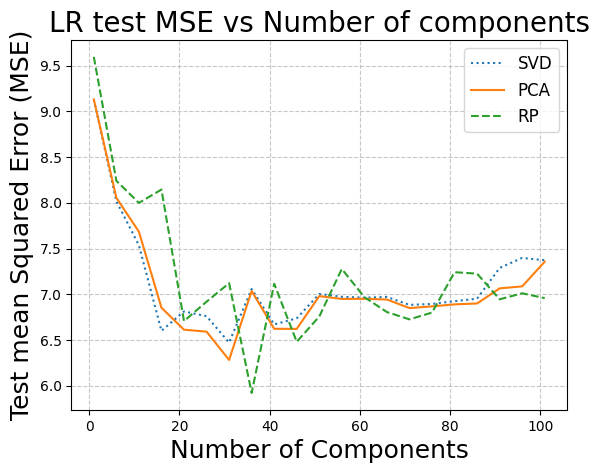

In [ ]:
plt.plot(n_components_values, svd_mse_values, label='SVD', linestyle=':')
plt.plot(n_components_values, pca_mse_values, label='PCA')
plt.plot(n_components_values, rp_mse_values, label='RP', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Test mean Squared Error (MSE)', fontsize=18)
plt.title('LR test MSE vs Number of components',  fontsize=20)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()

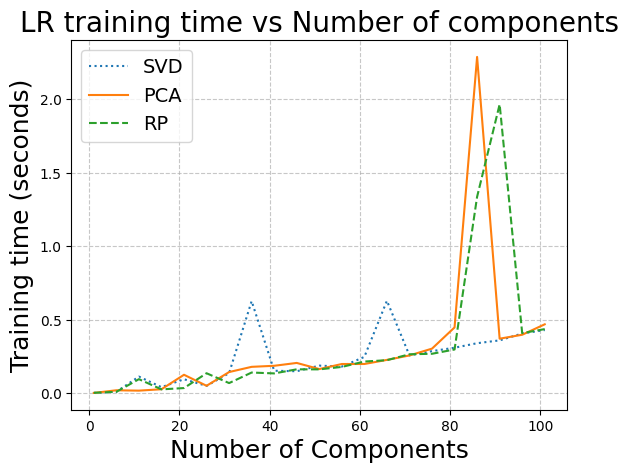

In [ ]:
plt.plot(n_components_values, svd_train_times, label='SVD', linestyle=':')
plt.plot(n_components_values, pca_train_times, label='PCA')
plt.plot(n_components_values, rp_train_times, label='RP', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Training time (seconds)', fontsize=18)
plt.title('LR training time vs Number of components',  fontsize=20)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability

In [ ]:
for n_components in n_components_values:
    print(f"N_components: {n_components}")
    print()
    xgb = XGBRegressor()
    training_loop(xgb, X_train, X_test, y_train, y_test, n_components = n_components)
    print()

N_components: 1

SVD - Mean Squared Error: 7.5368
SVD - Mean Absolute Error: 2.5727
SVD - Reduction time: 1.3714 seconds
SVD - Train time: 0.2420 seconds
PCA - Mean Squared Error: 7.5327
PCA - Mean Absolute Error: 2.5716
PCA - Reduction time: 1.1597 seconds
PCA - Train time: 1.2020 seconds
RP - Mean Squared Error: 8.0284
RP - Mean Absolute Error: 2.6685
RP - Reduction time: 0.2032 seconds
RP - Train time: 0.6675 seconds

N_components: 11

SVD - Mean Squared Error: 7.8449
SVD - Mean Absolute Error: 2.5956
SVD - Reduction time: 2.7101 seconds
SVD - Train time: 0.7827 seconds
PCA - Mean Squared Error: 8.0033
PCA - Mean Absolute Error: 2.6226
PCA - Reduction time: 0.9940 seconds
PCA - Train time: 0.7957 seconds
RP - Mean Squared Error: 7.9872
RP - Mean Absolute Error: 2.6370
RP - Reduction time: 0.2847 seconds
RP - Train time: 0.5604 seconds

N_components: 21

SVD - Mean Squared Error: 7.8504
SVD - Mean Absolute Error: 2.5936
SVD - Reduction time: 2.8677 seconds
SVD - Train time: 2.8235 se

In [ ]:
rp_mse_values = []
rp_mae_values = []
rp_reduction_times = []
rp_train_times = []
rp_history = []

for n_components in n_components_values:
    print(f"N_components: {n_components}")
    model = XGBRegressor()
    mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, 'rp', n_components=n_components)
    rp_mse_values.append(mse)
    rp_mae_values.append(mae)
    rp_reduction_times.append(reduction_time)
    rp_train_times.append(train_time)
    plt.figure(figsize=(10, 6))

svd_mse_values = []
svd_mae_values = []
svd_reduction_times = []
svd_train_times = []
svd_history = []

for n_components in n_components_values:
    print(f"N_components: {n_components}")
    model = XGBRegressor()
    mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, 'svd', n_components=n_components)
    svd_mse_values.append(mse)
    svd_mae_values.append(mae)
    svd_reduction_times.append(reduction_time)
    svd_train_times.append(train_time)
    plt.figure(figsize=(10, 6))

pca_mse_values = []
pca_mae_values = []
pca_reduction_times = []
pca_train_times = []
pca_history = []

for n_components in n_components_values:
    print(f"N_components: {n_components}")
    model = XGBRegressor()
    mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, 'pca', n_components=n_components)
    pca_mse_values.append(mse)
    pca_mae_values.append(mae)
    pca_reduction_times.append(reduction_time)
    pca_train_times.append(train_time)
    plt.figure(figsize=(10, 6))

N_components: 1
N_components: 6
N_components: 11
N_components: 16
N_components: 21
N_components: 26
N_components: 31
N_components: 36
N_components: 41
N_components: 46
N_components: 51
N_components: 56
N_components: 61
N_components: 66
N_components: 71
N_components: 76
N_components: 81
N_components: 86
N_components: 91
N_components: 96
N_components: 101
N_components: 1
N_components: 6
N_components: 11
N_components: 16
N_components: 21
N_components: 26
N_components: 31
N_components: 36
N_components: 41
N_components: 46
N_components: 51
N_components: 56
N_components: 61
N_components: 66
N_components: 71
N_components: 76
N_components: 81
N_components: 86
N_components: 91
N_components: 96
N_components: 101
N_components: 1
N_components: 6
N_components: 11
N_components: 16
N_components: 21
N_components: 26
N_components: 31
N_components: 36
N_components: 41
N_components: 46
N_components: 51
N_components: 56
N_components: 61
N_components: 66
N_components: 71
N_components: 76
N_components: 81
N

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

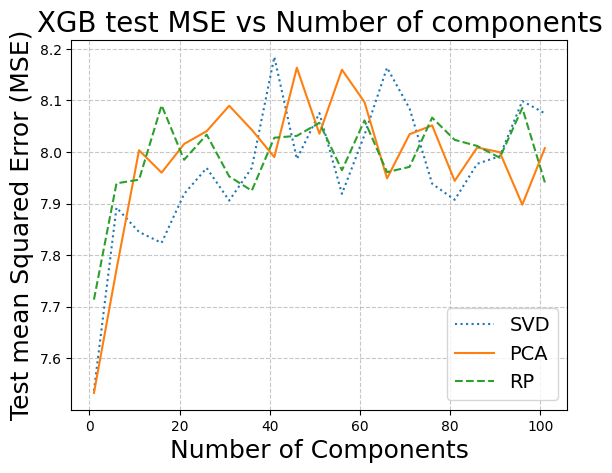

In [ ]:
plt.plot(n_components_values, svd_mse_values, label='SVD', linestyle=':')
plt.plot(n_components_values, pca_mse_values, label='PCA')
plt.plot(n_components_values, rp_mse_values, label='RP', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Test mean Squared Error (MSE)', fontsize=18)
plt.title('XGB test MSE vs Number of components',  fontsize=20)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()

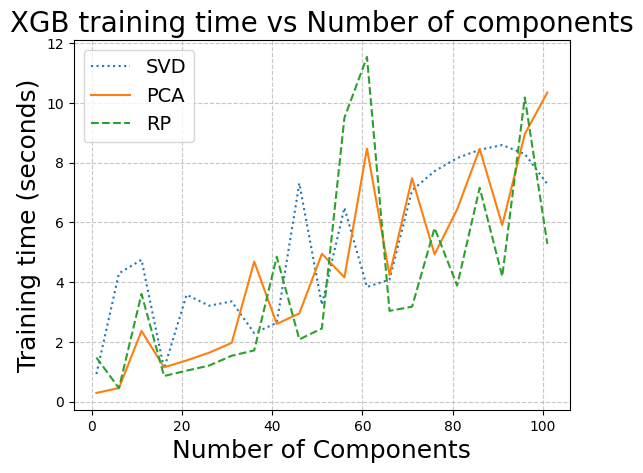

In [ ]:
plt.plot(n_components_values, svd_train_times, label='SVD', linestyle=':')
plt.plot(n_components_values, pca_train_times, label='PCA')
plt.plot(n_components_values, rp_train_times, label='RP', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Training time (seconds)', fontsize=18)
plt.title('XGB training time vs Number of components',  fontsize=20)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()

In [ ]:
start_time = time()  # Record the start time

xgb_raw = XGBRegressor()
xgb_raw.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = xgb_raw.predict(X_test.reshape(X_test.shape[0], -1))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

end_time = time()  # Record the end time
execution_time = end_time - start_time
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Execution Time: {execution_time} seconds")

Mean Squared Error: 7.5992386891578105
Mean Absolute Error: 2.5459630457816496
Execution Time: 22.969086170196533 seconds


In [ ]:
start_time = time()  # Record the start time

lin_raw = LinearRegression()
lin_raw.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = lin_raw.predict(X_test.reshape(X_test.shape[0], -1))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

end_time = time()  # Record the end time
execution_time = end_time - start_time
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Execution Time: {execution_time} seconds")

Mean Squared Error: 7.210503707379171
Mean Absolute Error: 2.4995040237022526
Execution Time: 3.0912487506866455 seconds


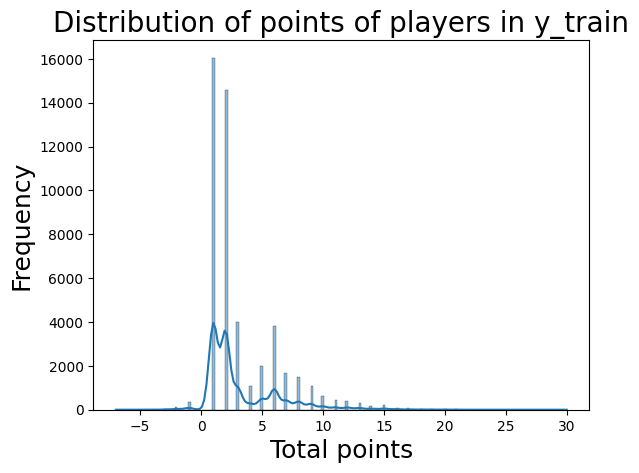

In [ ]:
sns.histplot(y_train, kde=True)
plt.title("Distribution of points of players in y_train", fontsize = 20)
plt.xlabel('Total points', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()

# Define helper functions to train and evaluate the models

In [ ]:
# Function to apply dimensionality reduction and train a model

def train_model_with_reduction(model, X_train, X_test, y_train, y_test, method, n_components=100):
    start_time = time()
    match method:
        case 'svd':
            reducer = TruncatedSVD(n_components=n_components)
        case 'pca':
            reducer = PCA(n_components=n_components)
        case 'rp':
            reducer = GaussianRandomProjection(n_components=n_components)  # Random Projection
        case _:
            raise ValueError("Invalid dimensionality reduction method.")

    # Reshape before reduction
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

    # Apply dimensionality reduction
    X_train_reduced = reducer.fit_transform(X_train_reshaped)
    X_test_reduced = reducer.transform(X_test_reshaped)

    reduction_time = time() - start_time

    start_time = time()
    model.fit(X_train_reduced, y_train) # Set verbose=0 to suppress training output
    train_time = time() - start_time

    y_pred = model.predict(X_test_reduced)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, mae, reduction_time, train_time




def train_neural_network_with_reduction(model, X_train, X_test, y_train, y_test, method, n_components=100, epochs = 20):
    start_time = time()
    match method:
        case 'svd':
            reducer = TruncatedSVD(n_components=n_components)
        case 'pca':
            reducer = PCA(n_components=n_components)
        case 'rp':
            reducer = GaussianRandomProjection(n_components=n_components)  # Random Projection
        case _:
            raise ValueError("Invalid dimensionality reduction method.")

    # Reshape before reduction
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

    # Apply dimensionality reduction
    X_train_reduced = reducer.fit_transform(X_train_reshaped)
    X_test_reduced = reducer.transform(X_test_reshaped)

    reduction_time = time() - start_time

    start_time = time()
    history = model.fit(X_train_reduced,
                    y_train,
                    validation_data=(X_test_reduced, y_test),
                    epochs=epochs)
    train_time = time() - start_time

    y_pred = model.predict(X_test_reduced)
    mse = mean_squared_error(y_test, y_pred)

    return mse, reduction_time, train_time, history



# Test different dimensionality reduction methods
def training_loop(model, X_train, X_test, y_train, y_test, n_components=100):
    methods = ['svd', 'pca', 'rp']
    results = {}
    time = 0
    for method in methods:
        mse, mae, reduction_time, train_time = train_model_with_reduction(model, X_train, X_test, y_train, y_test, method, n_components = n_components)
        results[method] = {
            'mse': mse,
            'mae': mae,
            'reduction_time': reduction_time,
            'train_time': train_time,
        }
        time += train_time
        print(f"{method.upper()} - Mean Squared Error: {mse:.4f}")
        print(f"{method.upper()} - Mean Absolute Error: {mae:.4f}")
        print(f"{method.upper()} - Reduction time: {reduction_time:.4f} seconds")
        print(f"{method.upper()} - Train time: {train_time:.4f} seconds")
        return time, mse
    return time, mse


def neural_model_training_loop(model, X_train, X_test, y_train, y_test):
    methods = ['svd', 'pca', 'rp']
    results = {}

    for method in methods:
        mse, reduction_time, train_time, history = train_neural_network_with_reduction(model, X_train, X_test, y_train, y_test, method)
        results[method] = {
            'mse': mse,
            'reduction_time': reduction_time,
            'train_time': train_time,
            # 'history': history
        }
        print(f"{method.upper()} - Mean Squared Error: {mse:.4f}")
        print(f"{method.upper()} - Reduction time: {reduction_time:.4f} seconds")
        print(f"{method.upper()} - Train time: {train_time:.4f} seconds")



# Create the models we are going to use

1. Linear Regression

In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

2. Small Neural Network

In [ ]:
neural_model_small = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,)),  # Flatten the input tensor
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
neural_model_small.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

3. Large Neural Network

In [ ]:
neural_model_large = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,)),  # Flatten the input tensor
    tf.keras.layers.Dense(256, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
neural_model_large.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

4. XGBRegressor

In [ ]:
xgb_model = XGBRegressor()

# Fit and evaluate the models

1. Fit Linear Regression

In [ ]:
training_loop(linear_model, X_train, X_test, y_train, y_test)

SVD - Mean Squared Error: 7.3714
SVD - Mean Absolute Error: 2.5424
SVD - Reduction time: 6.9525 seconds
SVD - Train time: 0.4917 seconds
PCA - Mean Squared Error: 7.3532
PCA - Mean Absolute Error: 2.5388
PCA - Reduction time: 3.1075 seconds
PCA - Train time: 2.3742 seconds
RP - Mean Squared Error: 6.8116
RP - Mean Absolute Error: 2.4312
RP - Reduction time: 0.7225 seconds
RP - Train time: 0.5048 seconds


2. Fit Small Neural Network

In [ ]:
neural_model_training_loop(neural_model_small, X_train, X_test, y_train, y_test)

Epoch 1/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 76449064.0000 - mean_absolute_error: 2098.8882 - val_loss: 601629.5000 - val_mean_absolute_error: 130.3786
Epoch 2/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2314119.0000 - mean_absolute_error: 565.5245 - val_loss: 622624.8750 - val_mean_absolute_error: 130.1378
Epoch 3/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 3036885.2500 - mean_absolute_error: 624.8636 - val_loss: 819071.8750 - val_mean_absolute_error: 194.0890
Epoch 4/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2286890.5000 - mean_absolute_error: 543.8564 - val_loss: 628729.0625 - val_mean_absolute_error: 151.1427
Epoch 5/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3317334.0000 - mean_absolute_error: 568.8315 - val_loss: 404642.1562 - val_mean_absolute_error: 126.1807
Epoch 6/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 673238.8750 - mean_absolute_error: 291.1477 - val_loss: 23215112.0000 - val_mean_absolute_error: 10

In [ ]:
neural_model_small.summary()

3. Fit Large Neural Network

In [ ]:
neural_model_training_loop(neural_model_large, X_train, X_test, y_train, y_test)

Epoch 1/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 82914376.0000 - mean_absolute_error: 1909.7693 - val_loss: 171797.3281 - val_mean_absolute_error: 74.3354
Epoch 2/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 942920.6250 - mean_absolute_error: 312.4214 - val_loss: 711486.8750 - val_mean_absolute_error: 185.5898
Epoch 3/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 870946.0625 - mean_absolute_error: 306.8051 - val_loss: 197354.9375 - val_mean_absolute_error: 87.8883
Epoch 4/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1094412.3750 - mean_absolute_error: 308.5911 - val_loss: 114836.9844 - val_mean_absolute_error: 62.2578
Epoch 5/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 665806.0625 - mean_absolute_error: 263.1634 - val_loss: 130966.2656 - val_mean_absolute_error: 76.3823
Epoch 6/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3978116.5000 - mean_absolute_error: 504.7377 - val_loss: 312110.3125 - val_mean_absolute_error: 122.6551

In [ ]:
neural_model_large.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,365 (810.02 KB)

 Trainable params: 69,121 (270.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 138,244 (540.02 KB)

4. Fit XGBRegressor

In [ ]:
training_loop(xgb_model, X_train, X_test, y_train, y_test)

SVD - Mean Squared Error: 7.9433
SVD - Reduction time: 6.8184 seconds
SVD - Train time: 9.7928 seconds
PCA - Mean Squared Error: 8.0777
PCA - Reduction time: 1.5229 seconds
PCA - Train time: 8.5816 seconds
RP - Mean Squared Error: 8.0754
RP - Reduction time: 1.3191 seconds
RP - Train time: 4.8638 seconds


In [ ]:
params = xgb_model.get_params()
print(params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
